In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import seaborn as sns
import anndata
import string
import gc
from anndata import read_h5ad
from anndata import read_csv
from pandas import DataFrame
import h5py
import os
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import networkx as nx
import plotly.graph_objects as go
import scanpy as sc

/home/anton.thieme/miniconda3/envs/sc_env/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)


In [2]:
# PATHS

# BOOLEANS

In [3]:
adata_tf = read_h5ad(os.path.join('..', 'data', 'adata_tf.h5ad'))
adata_tf

AnnData object with n_obs × n_vars = 1093048 × 1637
    obs: 'donor', 'tissue', 'anatomical_position', 'method', 'cdna_plate', 'library_plate', 'notes', 'cdna_well', 'old_index', 'assay', 'sample_id', 'replicate', '10X_run', '10X_barcode', 'ambient_removal', 'donor_method', 'donor_assay', 'donor_tissue', 'donor_tissue_assay', 'cell_ontology_class', 'cell_ontology_id', 'compartment', 'broad_cell_class', 'free_annotation', 'manually_annotated', 'published_2022', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ercc', 'pct_counts_ercc', '_scvi_batch', '_scvi_labels', 'scvi_leiden_donorassay_full', 'age', 'sex', 'ethnicity', 'sample_number'
    var: 'ensembl_id', 'gene_symbol', 'genome', 'mt', 'ercc', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std'
    uns: '_scvi_manager_uuid', '_scvi_uuid', '_training_mode', 'age_colors', 'assay_colors', 'compartment_colors', 'donor_colors', 'leiden', 'log1p', 'method_colors

In [4]:
adata_tf.layers['log_normalized']

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 230373053 stored elements and shape (1093048, 1637)>

In [9]:
sc.tl.pca(adata_tf, n_comps=50, svd_solver='arpack')
adata_tf.obsm['X_pca']

array([[ 3.441468  ,  4.522237  , -1.2851397 , ...,  0.60081375,
        -0.670879  , -1.107567  ],
       [ 1.7431852 , -3.5806558 ,  5.894796  , ..., -0.0658133 ,
         0.24725899, -0.1055054 ],
       [ 3.7293823 , -1.8634572 ,  5.240303  , ..., -0.38052496,
         0.6495772 , -0.22579733],
       ...,
       [ 7.3735113 ,  1.0802875 ,  3.2002892 , ...,  0.92885613,
        -0.4907385 , -0.50389403],
       [-3.9553823 ,  1.1896985 ,  1.4690025 , ..., -1.2855725 ,
        -0.8527264 , -0.6619931 ],
       [ 2.4677057 ,  0.9412613 , -0.54306126, ...,  0.2692278 ,
         1.4657577 ,  0.7285391 ]], dtype=float32)

In [17]:
corr_matrix = cosine_similarity(adata_tf.layers['log_normalized'].T)

In [20]:
corr_matrix.shape

(1637, 1637)

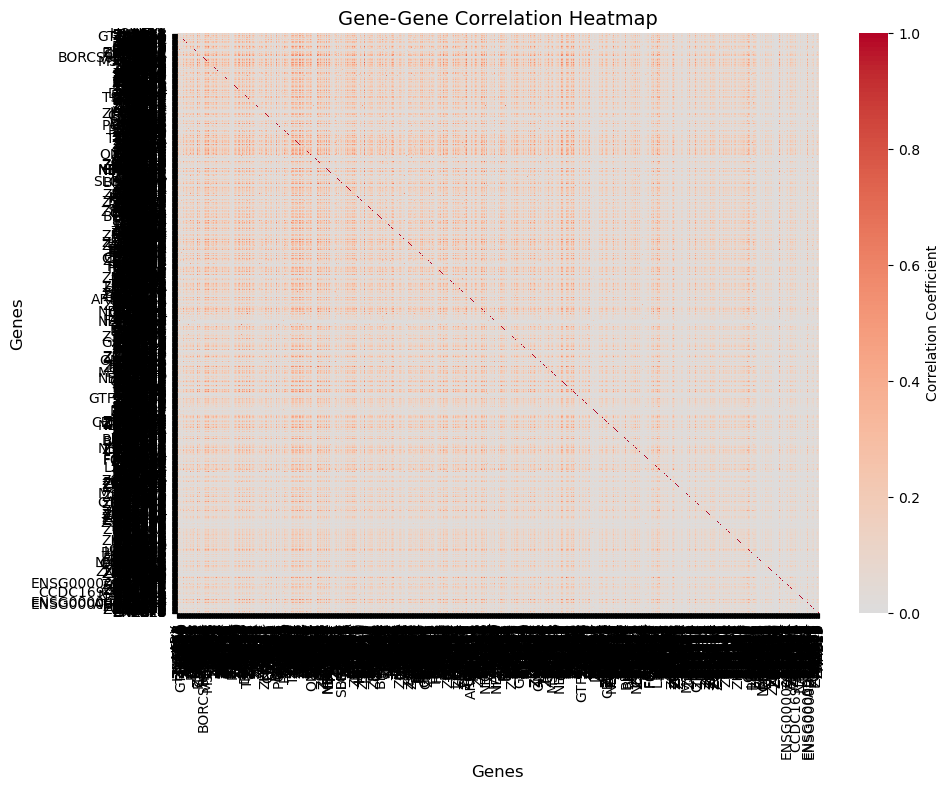

In [21]:
# correlation_matrix: (num_genes x num_genes) matrix
# Assign gene names as row/column labels if available
gene_names = adata_tf.var.index.tolist()  # List of gene names

# Create the heatmap
plt.figure(figsize=(10, 8))  # Adjust size as needed
sns.heatmap(
    corr_matrix, 
    xticklabels=gene_names, 
    yticklabels=gene_names,
    cmap="coolwarm",  # Choose a diverging color map for correlations
    center=0,         # Center the colormap at 0 (neutral correlation)
    cbar_kws={"label": "Correlation Coefficient"}  # Label for the color bar
)

# Add titles and labels
plt.title("Gene-Gene Correlation Heatmap", fontsize=14)
plt.xlabel("Genes", fontsize=12)
plt.ylabel("Genes", fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

/hpc/user_apps/data.science/conda_envs/single-cell-base/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/hpc/user_apps/data.science/conda_envs/single-cell-base/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


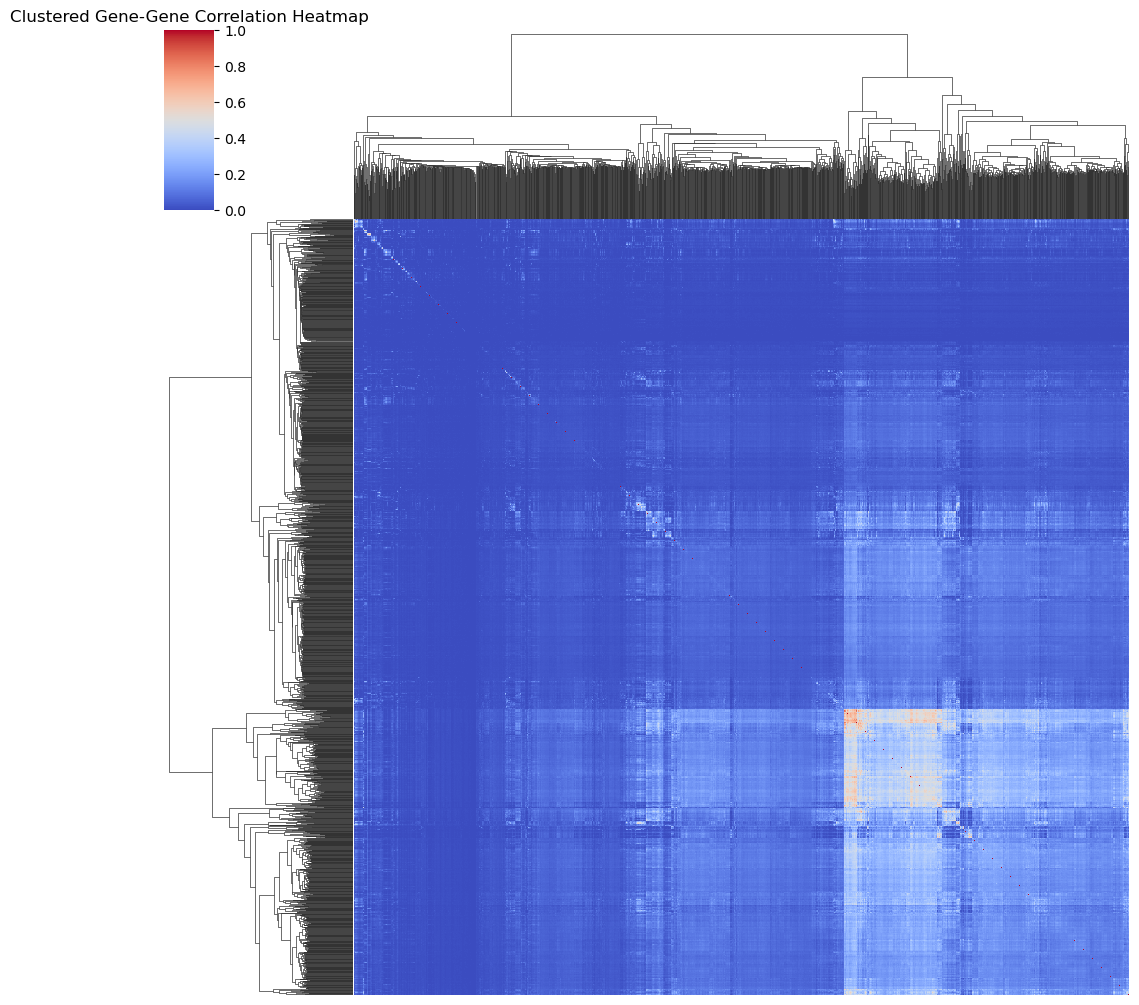

In [23]:
sns.clustermap(
    corr_matrix, 
    xticklabels=False, 
    yticklabels=False,
    cmap="coolwarm", 
    figsize=(10, 10)
)
plt.title("Clustered Gene-Gene Correlation Heatmap")
plt.show()

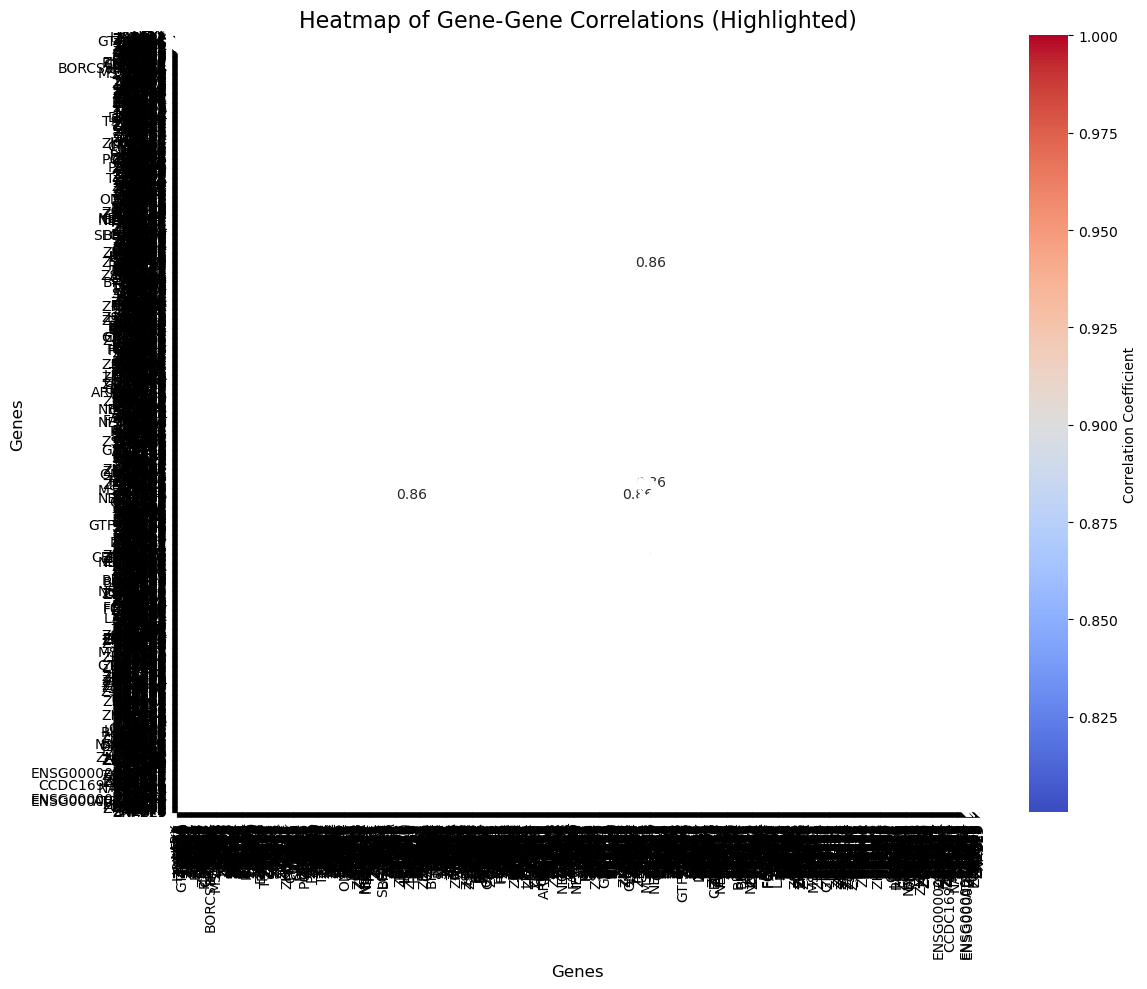

In [25]:
# Example: Correlation threshold
threshold = 0.8

# Identify highly correlated pairs (absolute value for both positive and negative)
high_corr = np.abs(corr_matrix) >= threshold

# Mask non-highlighted cells
mask = ~high_corr  # Invert the condition to mask non-highlighted cells

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix, 
    mask=mask,  # Mask cells outside the threshold
    cmap="coolwarm", 
    annot=True,  # Annotate values in the cells
    fmt=".2f",   # Format to 2 decimal places
    xticklabels=gene_names, 
    yticklabels=gene_names,
    cbar_kws={"label": "Correlation Coefficient"}
)

# Highlight title and labels
plt.title("Heatmap of Gene-Gene Correlations (Highlighted)", fontsize=16)
plt.xlabel("Genes", fontsize=12)
plt.ylabel("Genes", fontsize=12)

# Adjust the layout for better display
plt.tight_layout()
plt.show()


In [28]:
corr_matrix

array([[1.0000048e+00, 3.0608375e-02, 3.0242858e-02, ..., 5.7618041e-02,
        2.6462551e-02, 2.7877538e-02],
       [3.0608375e-02, 9.9999714e-01, 8.7061606e-04, ..., 1.7128311e-02,
        2.9798636e-02, 5.0890045e-03],
       [3.0242858e-02, 8.7061606e-04, 9.9999744e-01, ..., 1.4983303e-02,
        9.7067412e-03, 9.2507889e-03],
       ...,
       [5.7618041e-02, 1.7128311e-02, 1.4983303e-02, ..., 1.0000005e+00,
        1.9492250e-02, 2.3215549e-02],
       [2.6462551e-02, 2.9798636e-02, 9.7067412e-03, ..., 1.9492250e-02,
        9.9999917e-01, 3.7159037e-02],
       [2.7877538e-02, 5.0890045e-03, 9.2507889e-03, ..., 2.3215549e-02,
        3.7159037e-02, 9.9999893e-01]], dtype=float32)

In [29]:
corr_matrix.shape

(1637, 1637)

In [35]:
gene_names = list(adata_tf.var.index)

In [38]:
# Step 1: Extract upper triangle indices (excluding diagonal)
num_genes = corr_matrix.shape[0]
upper_triangle_indices = np.triu_indices(num_genes, k=1)

# Step 2: Get the correlations from the upper triangle
correlations = corr_matrix[upper_triangle_indices]

# Step 3: Find the top 20 correlations and their indices
top_20_indices = np.argsort(correlations)[-100:]  # Indices of the top 20 correlations
top_20_gene_pairs = [
    (gene_names[upper_triangle_indices[0][i]], gene_names[upper_triangle_indices[1][i]], correlations[i])
    for i in top_20_indices
]

In [39]:
top_20_gene_pairs

[('GPBP1', 'ZBTB20', 0.68743277),
 ('JUNB', 'CEBPB', 0.6878825),
 ('NR3C1', 'ELF1', 0.68794394),
 ('KLF5', 'EHF', 0.6882074),
 ('NFE2L2', 'ELF1', 0.6888157),
 ('KLF6', 'STAT3', 0.6892877),
 ('ASH1L', 'JUND', 0.6895735),
 ('GPBP1', 'SON', 0.69103205),
 ('IRF1', 'JUNB', 0.6914441),
 ('FOXO3', 'STAT3', 0.69195664),
 ('ELF1', 'BPTF', 0.69200534),
 ('NCOA1', 'ELF2', 0.6922192),
 ('JUNB', 'ZBTB20', 0.69270146),
 ('ELF1', 'JUNB', 0.6932763),
 ('GPBP1', 'ASH1L', 0.6937877),
 ('NCOA1', 'STAT3', 0.69412345),
 ('PRDM2', 'ELF1', 0.69562745),
 ('ELF1', 'KDM2A', 0.69604886),
 ('ASH1L', 'STAT3', 0.6963149),
 ('ASH1L', 'BPTF', 0.6964221),
 ('JUN', 'ZBTB20', 0.6964279),
 ('NFE2L2', 'SON', 0.69745415),
 ('GPBP1', 'JUND', 0.6978835),
 ('EGR1', 'ATF3', 0.6996248),
 ('TCF12', 'SON', 0.7002641),
 ('NR4A1', 'FOS', 0.7012777),
 ('SON', 'BPTF', 0.70320296),
 ('YBX1', 'JUNB', 0.70322317),
 ('KLF6', 'FOSB', 0.7036268),
 ('YBX3', 'YBX1', 0.7036474),
 ('ELF2', 'FOXO3', 0.7037432),
 ('JUND', 'ARID5B', 0.7039001),
 

In [42]:
corr_matrix

array([[1.0000048e+00, 3.0608375e-02, 3.0242858e-02, ..., 5.7618041e-02,
        2.6462551e-02, 2.7877538e-02],
       [3.0608375e-02, 9.9999714e-01, 8.7061606e-04, ..., 1.7128311e-02,
        2.9798636e-02, 5.0890045e-03],
       [3.0242858e-02, 8.7061606e-04, 9.9999744e-01, ..., 1.4983303e-02,
        9.7067412e-03, 9.2507889e-03],
       ...,
       [5.7618041e-02, 1.7128311e-02, 1.4983303e-02, ..., 1.0000005e+00,
        1.9492250e-02, 2.3215549e-02],
       [2.6462551e-02, 2.9798636e-02, 9.7067412e-03, ..., 1.9492250e-02,
        9.9999917e-01, 3.7159037e-02],
       [2.7877538e-02, 5.0890045e-03, 9.2507889e-03, ..., 2.3215549e-02,
        3.7159037e-02, 9.9999893e-01]], dtype=float32)

In [48]:
corr_matrix_ltri = corr_matrix[np.triu_indices(corr_matrix.shape[0], k=1)]
corr_matrix_ltri

array([0.03060837, 0.03024286, 0.04678382, ..., 0.01949225, 0.02321555,
       0.03715904], dtype=float32)

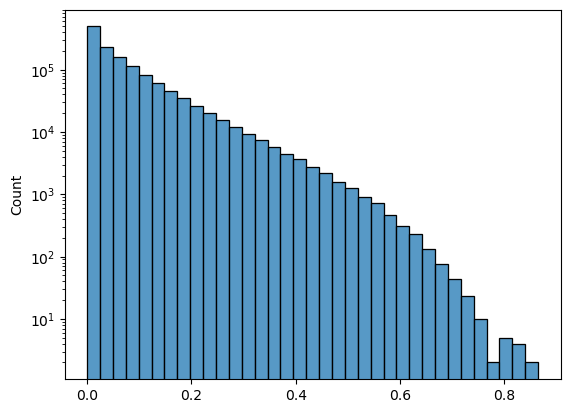

In [50]:
sns.histplot(corr_matrix_ltri, binwidth=0.025)
plt.yscale('log')
plt.show()

In [ ]:
correlation_matrix = corr_matrix
# Step 1: Threshold the correlation matrix
threshold = 0.0  # Keep only correlations above this value
adjacency_matrix = (correlation_matrix > threshold).astype(int)

# Step 2: Create the graph
graph = nx.Graph()

# Add nodes with gene names as labels
for idx, gene in enumerate(gene_names):
    graph.add_node(idx, label=gene)

# Add edges for high correlations
for i in range(adjacency_matrix.shape[0]):
    for j in range(i + 1, adjacency_matrix.shape[1]):  # Use upper triangle of the matrix
        if adjacency_matrix[i, j] == 1:
            graph.add_edge(i, j, weight=correlation_matrix[i, j])

# Step 3: Generate positions for the nodes using a force-directed layout
pos = nx.spring_layout(graph, seed=42)  # Force-directed layout (deterministic with seed)

# Extract node positions
x_nodes = [pos[i][0] for i in graph.nodes()]  # X-coordinates of nodes
y_nodes = [pos[i][1] for i in graph.nodes()]  # Y-coordinates of nodes
node_labels = [graph.nodes[i]['label'] for i in graph.nodes()]  # Gene names

# Extract edge positions
edge_x = []
edge_y = []
for edge in graph.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)  # Separate edges
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

# Step 4: Create Plotly traces for edges and nodes
edge_trace = go.Scatter(
    x=edge_x, 
    y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines'
)

node_trace = go.Scatter(
    x=x_nodes,
    y=y_nodes,
    mode='markers+text',
    text=node_labels,
    textposition="top center",
    hoverinfo='text',
    marker=dict(
        size=10,
        color='blue',
        line=dict(width=2, color='white')
    )
)

# Step 5: Create the figure
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title='Force-Directed Gene Correlation Network',
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=0, l=0, r=0, t=40),
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
                ))

# Show the interactive plot
fig.show()